# K-Means for Hearing Threshold Data Clustering - Re-weighting by Second Order Age

`Each participant's both ears are treated as if they were two participants.`

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

import seaborn as sns
import numpy as np

In [2]:
# Load the data
file_path = "../../data/nhanes_1520_age.csv"
data = pd.read_csv(file_path)
data.set_index('SEQN', inplace=True)
print(data.shape)
data.head()

(9729, 15)


,AUXU500R,AUXU1K1R,AUXU2KR,AUXU3KR,AUXU4KR,AUXU6KR,AUXU8KR,AUXU500L,AUXU1K1L,AUXU2KL,AUXU3KL,AUXU4KL,AUXU6KL,AUXU8KL,RIDAGEYR
SEQN,,,,,,,,,,,,,,,
83732,10.0,5.0,5.0,20.0,30.0,25.0,50.0,5.0,5.0,5.0,35.0,50.0,50.0,55.0,62
83733,10.0,15.0,40.0,55.0,60.0,55.0,65.0,5.0,20.0,50.0,55.0,60.0,55.0,60.0,53
83735,25.0,25.0,30.0,20.0,40.0,40.0,55.0,15.0,25.0,30.0,30.0,45.0,60.0,50.0,56
83736,10.0,10.0,10.0,15.0,10.0,15.0,20.0,15.0,10.0,15.0,25.0,15.0,25.0,20.0,42
83741,5.0,0.0,5.0,5.0,5.0,20.0,15.0,0.0,-5.0,0.0,5.0,-5.0,10.0,10.0,22


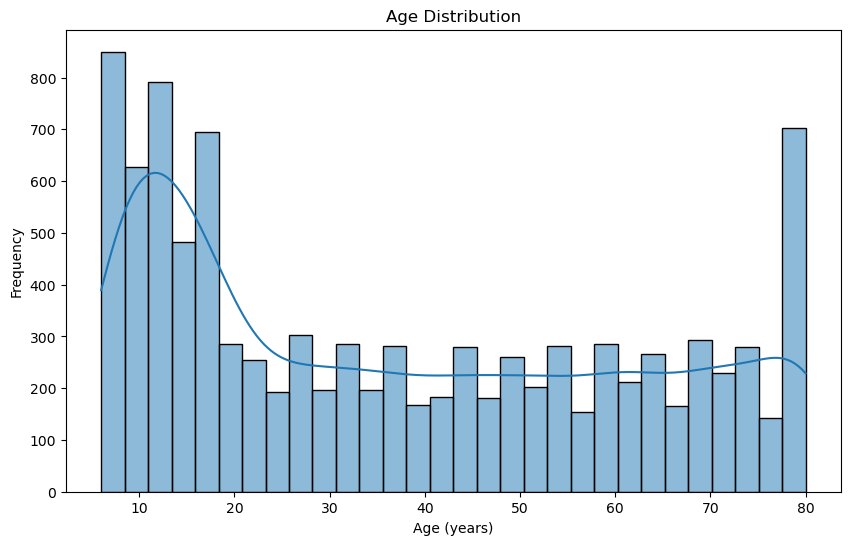

In [3]:
# Check the age distribution in the column 'RIDAGEYR'
plt.figure(figsize=(10, 6))
sns.histplot(data['RIDAGEYR'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.show()

In [4]:
# Select the columns for right ear measurements

right_ear_columns = ['AUXU500R', 'AUXU1K1R', 'AUXU2KR', 'AUXU3KR', 'AUXU4KR', 'AUXU6KR', 'AUXU8KR', 'RIDAGEYR']
right_ear_data = data[right_ear_columns]
right_ear_data.columns = ['500 Hz', '1 kHz', '2 kHz', '3 kHz', '4 kHz', '6 kHz', '8 kHz', 'Age']

# Select the columns for left ear measurements

left_ear_columns = ['AUXU500L', 'AUXU1K1L', 'AUXU2KL', 'AUXU3KL', 'AUXU4KL', 'AUXU6KL', 'AUXU8KL', 'RIDAGEYR']
left_ear_data = data[left_ear_columns]
left_ear_data.columns = ['500 Hz', '1 kHz', '2 kHz', '3 kHz', '4 kHz', '6 kHz', '8 kHz', 'Age']

# Concatenate the right and left ear data

ear_data = pd.concat([right_ear_data, left_ear_data], axis=0)

ear_data

,500 Hz,1 kHz,2 kHz,3 kHz,4 kHz,6 kHz,8 kHz,Age
SEQN,,,,,,,,
83732,10.0,5.0,5.0,20.0,30.0,25.0,50.0,62
83733,10.0,15.0,40.0,55.0,60.0,55.0,65.0,53
83735,25.0,25.0,30.0,20.0,40.0,40.0,55.0,56
83736,10.0,10.0,10.0,15.0,10.0,15.0,20.0,42
83741,5.0,0.0,5.0,5.0,5.0,20.0,15.0,22
...,...,...,...,...,...,...,...,...
124797,888.0,0.0,-5.0,888.0,5.0,888.0,10.0,9
124799,20.0,40.0,45.0,45.0,60.0,85.0,666.0,80
124811,35.0,30.0,15.0,30.0,25.0,55.0,60.0,76


In [5]:
# Process missing values
cleaned_ear_data = ear_data.replace({888: np.nan, 666: np.nan, '.': np.nan}, inplace=False)
cleaned_ear_data = cleaned_ear_data.dropna(inplace=False)

# Extract the age column

age_data = cleaned_ear_data['Age']

# Turn age data into sample weights

age_weights = age_data ** 2 / (age_data ** 2).sum()

# Drop the age column from the cleaned_ear_data data

cleaned_ear_data.drop('Age', axis=1, inplace=True)

cleaned_ear_data

,500 Hz,1 kHz,2 kHz,3 kHz,4 kHz,6 kHz,8 kHz
SEQN,,,,,,,
83732,10.0,5.0,5.0,20.0,30.0,25.0,50.0
83733,10.0,15.0,40.0,55.0,60.0,55.0,65.0
83735,25.0,25.0,30.0,20.0,40.0,40.0,55.0
83736,10.0,10.0,10.0,15.0,10.0,15.0,20.0
83741,5.0,0.0,5.0,5.0,5.0,20.0,15.0
...,...,...,...,...,...,...,...
124784,45.0,50.0,50.0,50.0,50.0,45.0,80.0
124786,0.0,10.0,10.0,5.0,0.0,15.0,0.0
124787,20.0,10.0,5.0,5.0,5.0,10.0,5.0


In [6]:
# Standardize the data
standard_scaler = StandardScaler()
standard_scaled_data = standard_scaler.fit_transform(cleaned_ear_data)

# Min-max scaling
minmax_scaler = MinMaxScaler()
minmax_scaled_data = minmax_scaler.fit_transform(cleaned_ear_data)

# Robust scaling
## Note: Robust scaling is computed as (X - median) / IQR
robust_scaler = RobustScaler()
robust_scaled_data = robust_scaler.fit_transform(cleaned_ear_data)

# Quantile transformation
quantile_transformer = QuantileTransformer(output_distribution='normal')
quantile_transformed_data = quantile_transformer.fit_transform(cleaned_ear_data)

# K-Means with raw data

KMeans with 2 clusters
Silhouette Score: 0.598
Davies Bouldin Score: 0.649
Calinski Harabasz Score: 23022.265
--------------------------------------------------
KMeans with 3 clusters
Silhouette Score: 0.487
Davies Bouldin Score: 0.984
Calinski Harabasz Score: 18841.855
--------------------------------------------------
KMeans with 4 clusters
Silhouette Score: 0.401
Davies Bouldin Score: 1.162
Calinski Harabasz Score: 15984.485
--------------------------------------------------


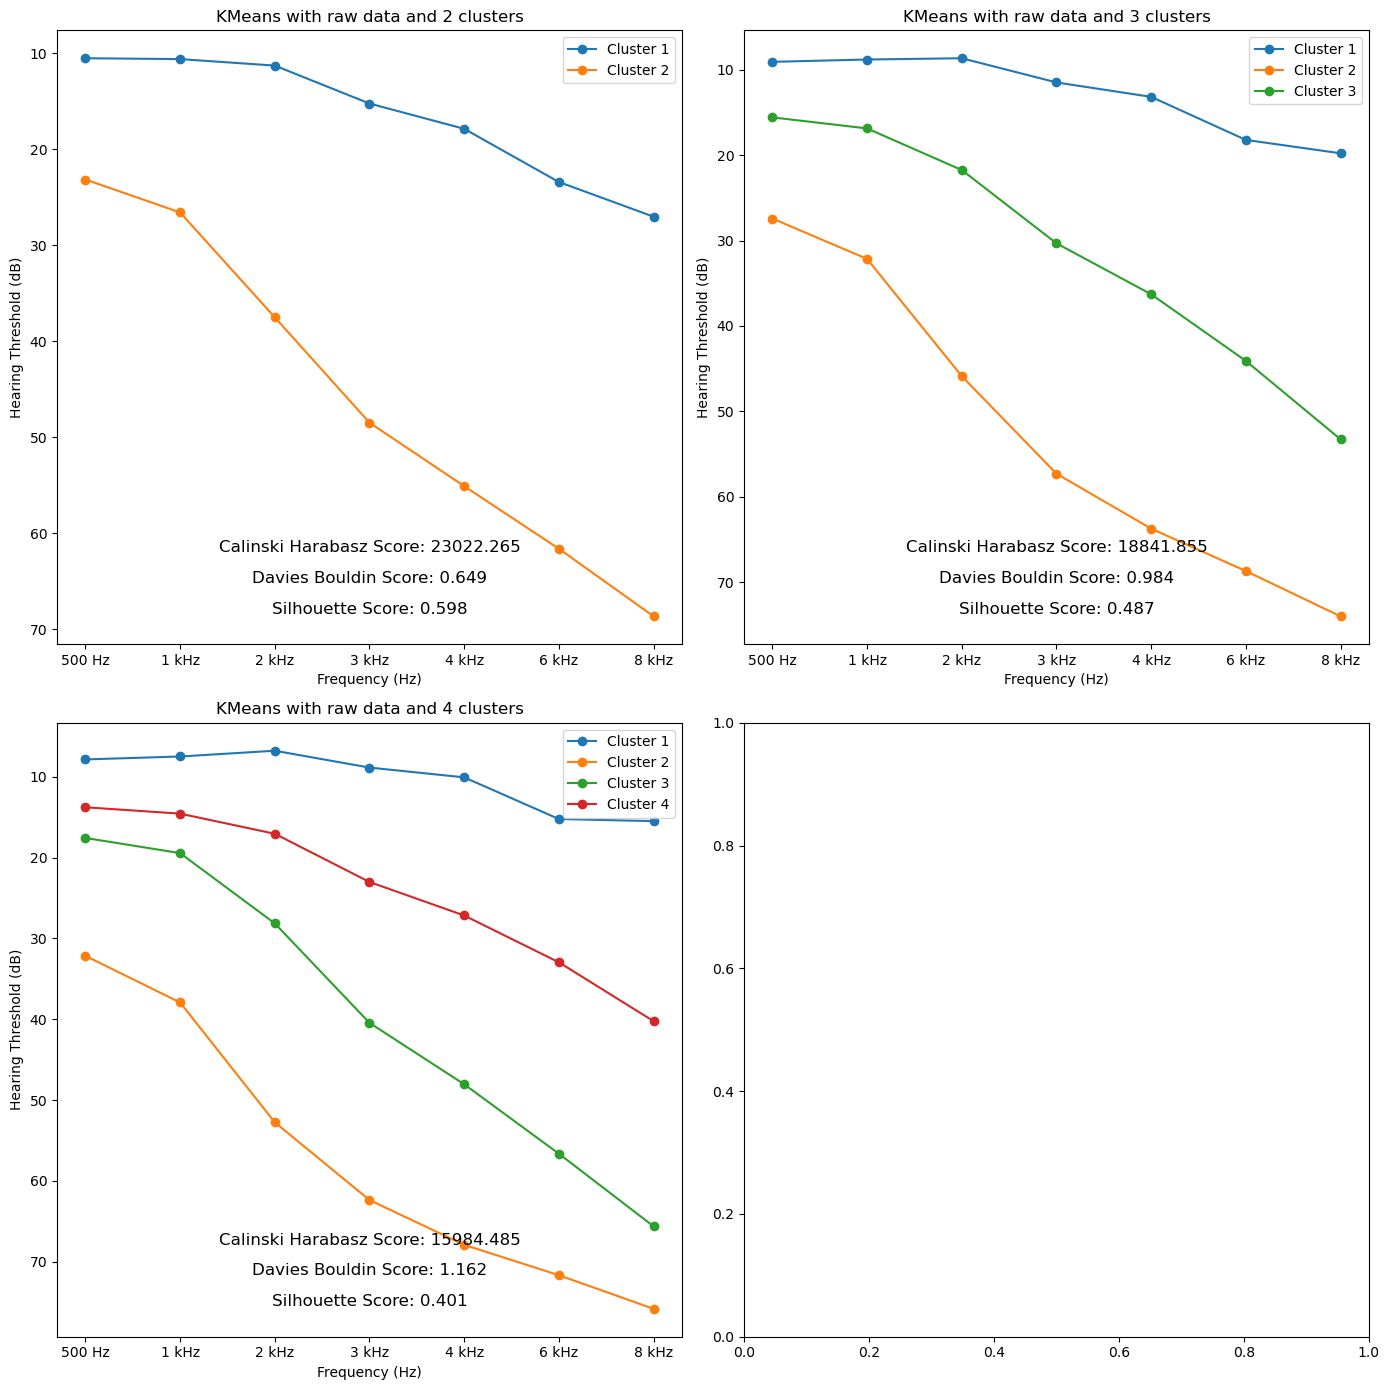

In [7]:
# Fit the K-Means algorithm with n clusters = 2, 3, 4

fig, ax = plt.subplots(2, 2, figsize=(14, 14))

for i in range(2, 5):
    # Initialize the KMeans object
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(cleaned_ear_data, sample_weight = age_weights)

    # Extract the centroids
    centroids = kmeans.cluster_centers_
    centroids_df = pd.DataFrame(centroids, columns=cleaned_ear_data.columns)

    # Plot the line plot
    row = (i - 2) // 2
    col = (i - 2) % 2
    for cluster_id in range(i):
        ax[row, col].plot(
            centroids_df.columns, 
            centroids_df.iloc[cluster_id], 
            marker='o', 
            label=f'Cluster {cluster_id + 1}'
        )
    ax[row, col].set_title(f'KMeans with raw data and {i} clusters')
    ax[row, col].set_xlabel('Frequency (Hz)')
    ax[row, col].set_ylabel('Hearing Threshold (dB)')
    ax[row, col].invert_yaxis()
    ax[row, col].legend()

    # Annotate the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(cleaned_ear_data, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(cleaned_ear_data, kmeans.labels_)

    ax[row, col].annotate(f'Silhouette Score: {silhouette:.3f}', 
                          xy=(0.5, 0.05), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Davies Bouldin Score: {davies_bouldin:.3f}',
                            xy=(0.5, 0.10), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Calinski Harabasz Score: {calinski_harabasz:.3f}',
                            xy=(0.5, 0.15), xycoords='axes fraction', ha='center', fontsize=12)
    
    # Print out the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    print(f'KMeans with {i} clusters')
    print(f'Silhouette Score: {silhouette:.3f}')
    print(f'Davies Bouldin Score: {davies_bouldin:.3f}')
    print(f'Calinski Harabasz Score: {calinski_harabasz:.3f}')
    print('-' * 50)

plt.tight_layout()
plt.show()

# K-Means with centered data

KMeans with 2 clusters
Silhouette Score: 0.589
Davies Bouldin Score: 0.654
Calinski Harabasz Score: 20532.418
--------------------------------------------------
KMeans with 3 clusters
Silhouette Score: 0.507
Davies Bouldin Score: 1.044
Calinski Harabasz Score: 16349.716
--------------------------------------------------
KMeans with 4 clusters
Silhouette Score: 0.426
Davies Bouldin Score: 1.232
Calinski Harabasz Score: 14155.068
--------------------------------------------------


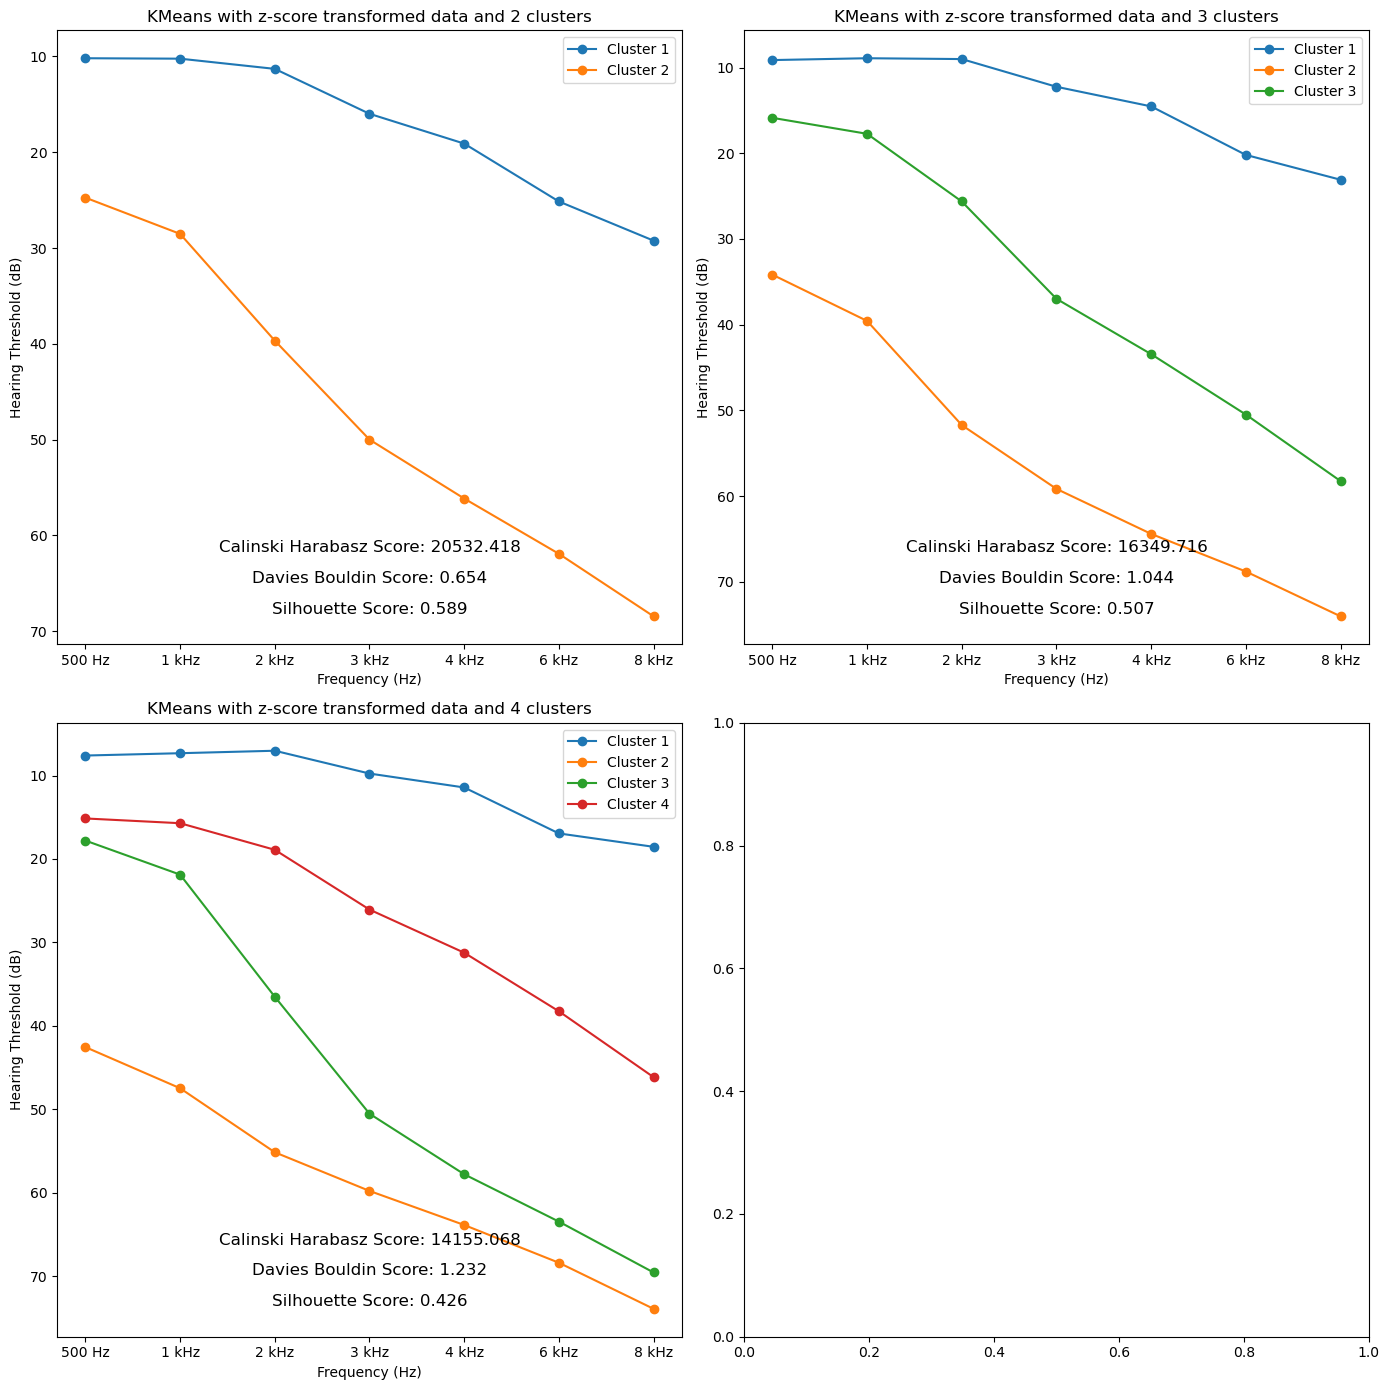

In [8]:
# Fit the K-Means algorithm with n clusters = 2, 3, 4

fig, ax = plt.subplots(2, 2, figsize=(14, 14))

for i in range(2, 5):
    # Initialize the KMeans object
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(standard_scaled_data, sample_weight = age_weights)

    # Extract the centroids
    centroids = standard_scaler.inverse_transform(kmeans.cluster_centers_)
    centroids_df = pd.DataFrame(centroids, columns=cleaned_ear_data.columns)

    # Plot the line plot
    row = (i - 2) // 2
    col = (i - 2) % 2
    for cluster_id in range(i):
        ax[row, col].plot(
            centroids_df.columns, 
            centroids_df.iloc[cluster_id], 
            marker='o', 
            label=f'Cluster {cluster_id + 1}'
        )
    ax[row, col].set_title(f'KMeans with z-score transformed data and {i} clusters')
    ax[row, col].set_xlabel('Frequency (Hz)')
    ax[row, col].set_ylabel('Hearing Threshold (dB)')
    ax[row, col].invert_yaxis()
    ax[row, col].legend()

    # Annotate the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(cleaned_ear_data, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(cleaned_ear_data, kmeans.labels_)

    ax[row, col].annotate(f'Silhouette Score: {silhouette:.3f}', 
                          xy=(0.5, 0.05), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Davies Bouldin Score: {davies_bouldin:.3f}',
                            xy=(0.5, 0.10), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Calinski Harabasz Score: {calinski_harabasz:.3f}',
                            xy=(0.5, 0.15), xycoords='axes fraction', ha='center', fontsize=12)
    
    # Print out the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    print(f'KMeans with {i} clusters')
    print(f'Silhouette Score: {silhouette:.3f}')
    print(f'Davies Bouldin Score: {davies_bouldin:.3f}')
    print(f'Calinski Harabasz Score: {calinski_harabasz:.3f}')
    print('-' * 50)

plt.tight_layout()
plt.show()

## KMeans with min-max standardized data

KMeans with 2 clusters
Silhouette Score: 0.598
Davies Bouldin Score: 0.650
Calinski Harabasz Score: 23078.080
--------------------------------------------------
KMeans with 3 clusters
Silhouette Score: 0.489
Davies Bouldin Score: 0.983
Calinski Harabasz Score: 18715.429
--------------------------------------------------
KMeans with 4 clusters
Silhouette Score: 0.401
Davies Bouldin Score: 1.156
Calinski Harabasz Score: 15952.849
--------------------------------------------------


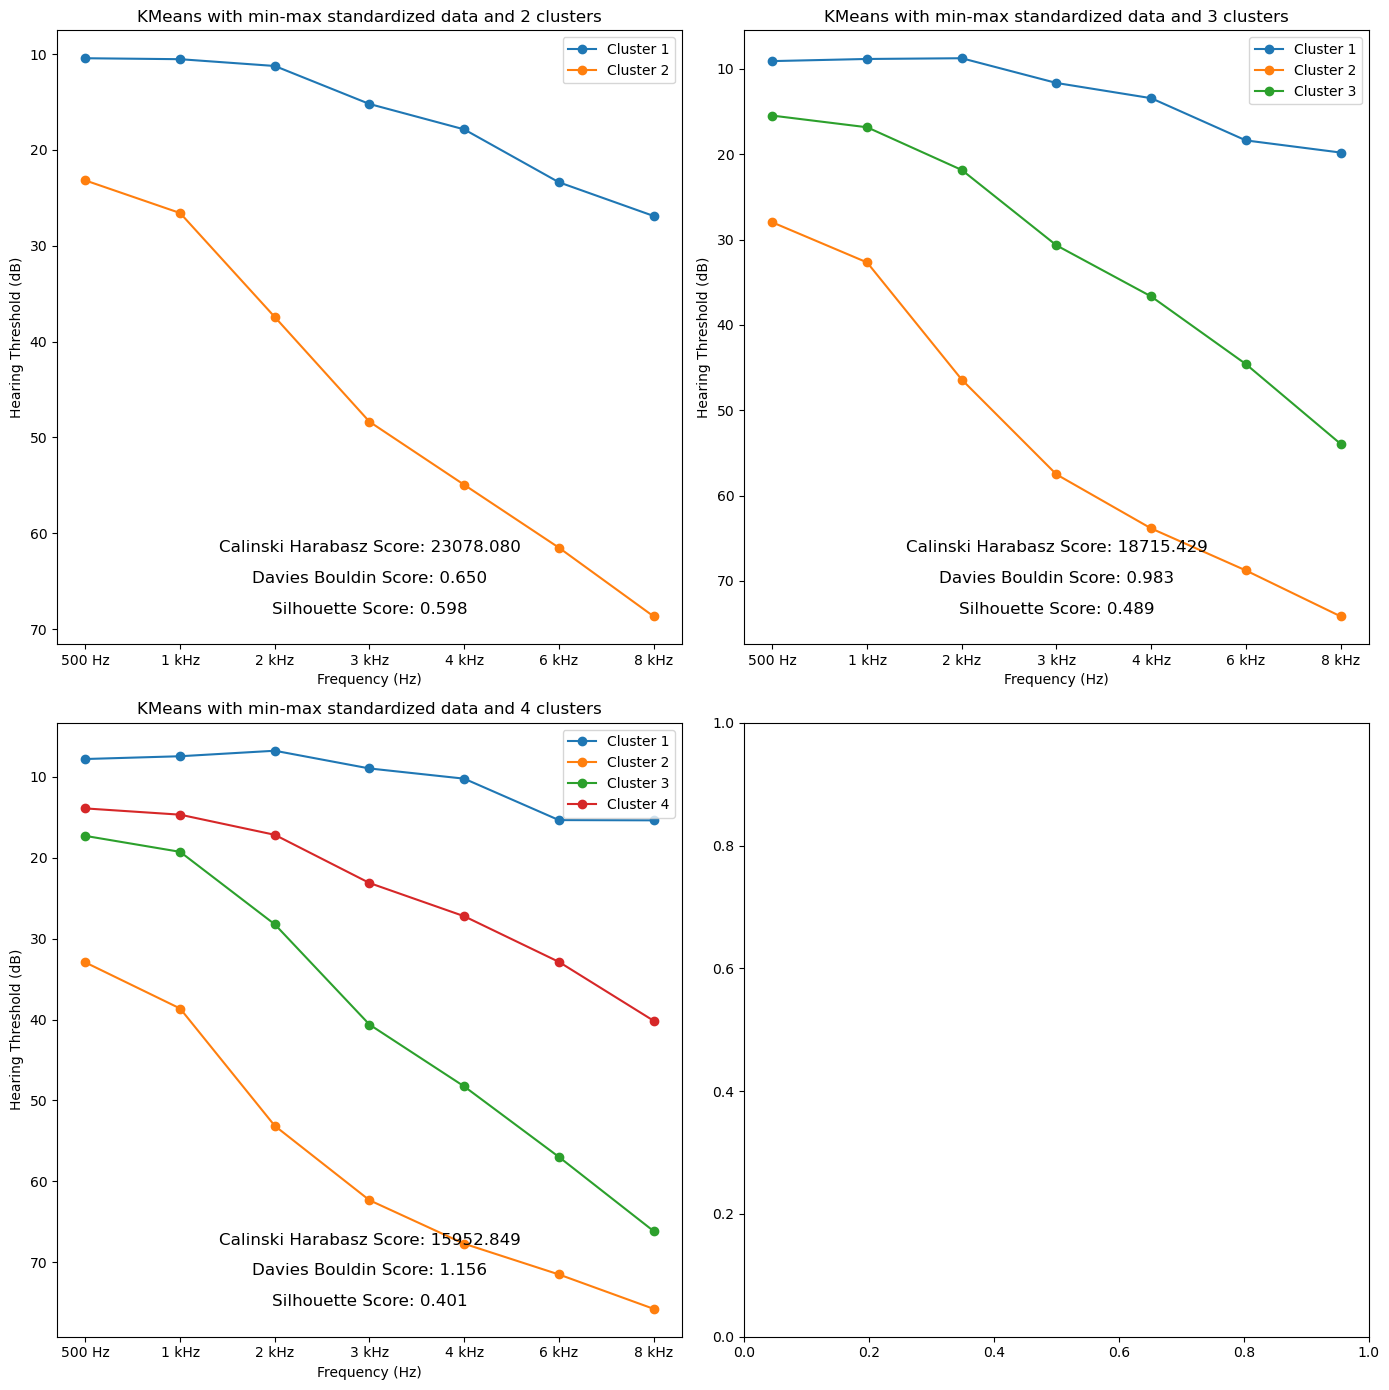

In [9]:
# K-Means with min-max standardized data

# Fit the K-Means algorithm with n clusters = 2, 3, 4

fig, ax = plt.subplots(2, 2, figsize=(14, 14))

for i in range(2, 5):
    # Initialize the KMeans object
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(minmax_scaled_data, sample_weight = age_weights)

    # Extract the centroids
    centroids = minmax_scaler.inverse_transform(kmeans.cluster_centers_)
    centroids_df = pd.DataFrame(centroids, columns=cleaned_ear_data.columns)

    # Plot the line plot
    row = (i - 2) // 2
    col = (i - 2) % 2
    for cluster_id in range(i):
        ax[row, col].plot(
            centroids_df.columns, 
            centroids_df.iloc[cluster_id], 
            marker='o', 
            label=f'Cluster {cluster_id + 1}'
        )
    ax[row, col].set_title(f'KMeans with min-max standardized data and {i} clusters')
    ax[row, col].set_xlabel('Frequency (Hz)')
    ax[row, col].set_ylabel('Hearing Threshold (dB)')
    ax[row, col].invert_yaxis()
    ax[row, col].legend()

    # Annotate the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(cleaned_ear_data, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(cleaned_ear_data, kmeans.labels_)

    ax[row, col].annotate(f'Silhouette Score: {silhouette:.3f}', 
                          xy=(0.5, 0.05), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Davies Bouldin Score: {davies_bouldin:.3f}',
                            xy=(0.5, 0.10), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Calinski Harabasz Score: {calinski_harabasz:.3f}',
                            xy=(0.5, 0.15), xycoords='axes fraction', ha='center', fontsize=12)
    
    # Print out the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    print(f'KMeans with {i} clusters')
    print(f'Silhouette Score: {silhouette:.3f}')
    print(f'Davies Bouldin Score: {davies_bouldin:.3f}')
    print(f'Calinski Harabasz Score: {calinski_harabasz:.3f}')
    print('-' * 50)

plt.tight_layout()
plt.show()

# K-Means with robust scaled data

KMeans with 2 clusters
Silhouette Score: 0.572
Davies Bouldin Score: 0.671
Calinski Harabasz Score: 17052.688
--------------------------------------------------
KMeans with 3 clusters
Silhouette Score: 0.492
Davies Bouldin Score: 1.091
Calinski Harabasz Score: 14536.163
--------------------------------------------------
KMeans with 4 clusters
Silhouette Score: 0.395
Davies Bouldin Score: 1.285
Calinski Harabasz Score: 12707.665
--------------------------------------------------


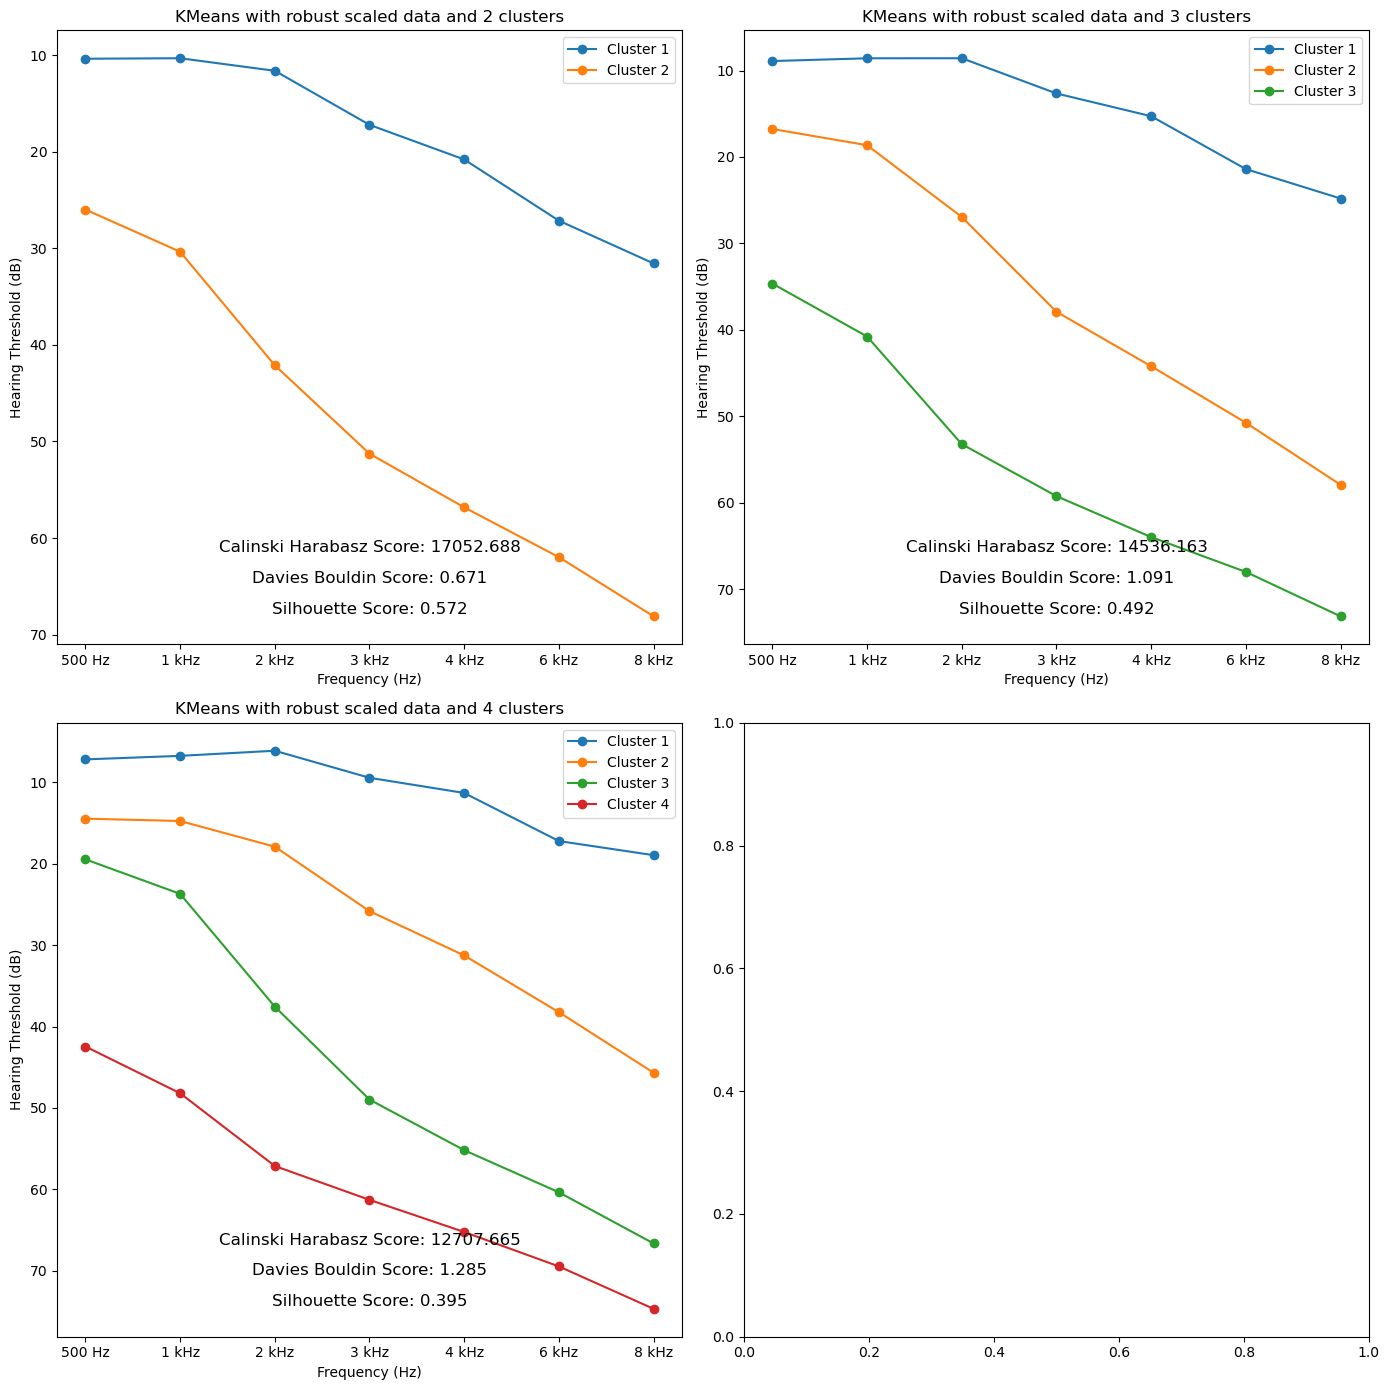

In [10]:
# K-Means with robust standardized data

# Fit the K-Means algorithm with n clusters = 2, 3, 4

fig, ax = plt.subplots(2, 2, figsize=(14, 14))

for i in range(2, 5):
    # Initialize the KMeans object
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(robust_scaled_data, sample_weight = age_weights)

    # Extract the centroids
    centroids = robust_scaler.inverse_transform(kmeans.cluster_centers_)
    centroids_df = pd.DataFrame(centroids, columns=cleaned_ear_data.columns)

    # Plot the line plot
    row = (i - 2) // 2
    col = (i - 2) % 2
    for cluster_id in range(i):
        ax[row, col].plot(
            centroids_df.columns, 
            centroids_df.iloc[cluster_id], 
            marker='o', 
            label=f'Cluster {cluster_id + 1}'
        )
    ax[row, col].set_title(f'KMeans with robust scaled data and {i} clusters')
    ax[row, col].set_xlabel('Frequency (Hz)')
    ax[row, col].set_ylabel('Hearing Threshold (dB)')
    ax[row, col].invert_yaxis()
    ax[row, col].legend()

    # Annotate the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(cleaned_ear_data, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(cleaned_ear_data, kmeans.labels_)

    ax[row, col].annotate(f'Silhouette Score: {silhouette:.3f}', 
                          xy=(0.5, 0.05), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Davies Bouldin Score: {davies_bouldin:.3f}',
                            xy=(0.5, 0.10), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Calinski Harabasz Score: {calinski_harabasz:.3f}',
                            xy=(0.5, 0.15), xycoords='axes fraction', ha='center', fontsize=12)
    
    # Print out the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    print(f'KMeans with {i} clusters')
    print(f'Silhouette Score: {silhouette:.3f}')
    print(f'Davies Bouldin Score: {davies_bouldin:.3f}')
    print(f'Calinski Harabasz Score: {calinski_harabasz:.3f}')
    print('-' * 50)

plt.tight_layout()
plt.show()

## K-Mean clustering with QuantileTransformed

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


KMeans with 2 clusters
Silhouette Score: 0.553
Davies Bouldin Score: 0.752
Calinski Harabasz Score: 21933.507
--------------------------------------------------


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


KMeans with 3 clusters
Silhouette Score: 0.377
Davies Bouldin Score: 1.016
Calinski Harabasz Score: 17124.839
--------------------------------------------------


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


KMeans with 4 clusters
Silhouette Score: 0.253
Davies Bouldin Score: 1.254
Calinski Harabasz Score: 14079.129
--------------------------------------------------


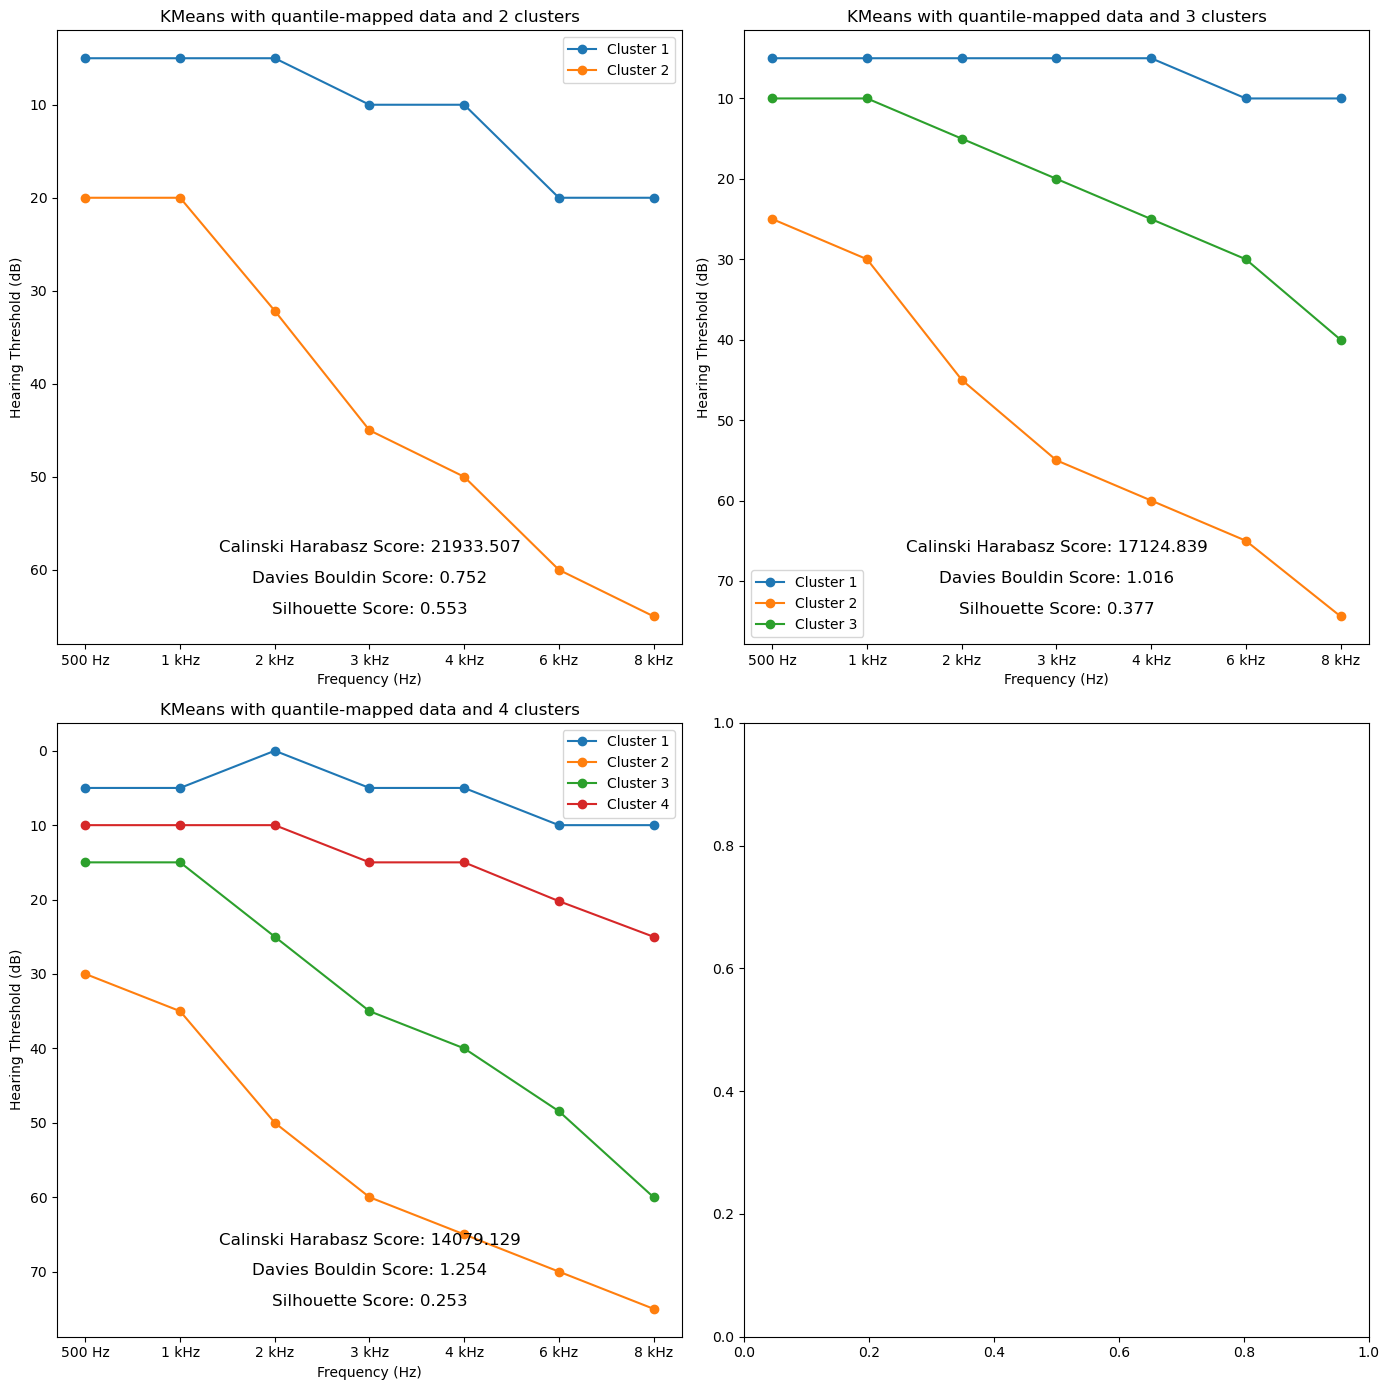

In [11]:
# K-Means with quantile standardized data

# Fit the K-Means algorithm with n clusters = 2, 3, 4

fig, ax = plt.subplots(2, 2, figsize=(14, 14))

for i in range(2, 5):
    # Initialize the KMeans object
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(quantile_transformed_data, sample_weight = age_weights)

    # Extract the centroids
    centroids = quantile_transformer.inverse_transform(kmeans.cluster_centers_)
    centroids_df = pd.DataFrame(centroids, columns=cleaned_ear_data.columns)

    # Plot the line plot
    row = (i - 2) // 2
    col = (i - 2) % 2
    for cluster_id in range(i):
        ax[row, col].plot(
            centroids_df.columns, 
            centroids_df.iloc[cluster_id], 
            marker='o', 
            label=f'Cluster {cluster_id + 1}'
        )
    ax[row, col].set_title(f'KMeans with quantile-mapped data and {i} clusters')
    ax[row, col].set_xlabel('Frequency (Hz)')
    ax[row, col].set_ylabel('Hearing Threshold (dB)')
    ax[row, col].invert_yaxis()
    ax[row, col].legend()

    # Annotate the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(cleaned_ear_data, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(cleaned_ear_data, kmeans.labels_)

    ax[row, col].annotate(f'Silhouette Score: {silhouette:.3f}', 
                          xy=(0.5, 0.05), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Davies Bouldin Score: {davies_bouldin:.3f}',
                            xy=(0.5, 0.10), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Calinski Harabasz Score: {calinski_harabasz:.3f}',
                            xy=(0.5, 0.15), xycoords='axes fraction', ha='center', fontsize=12)
    
    # Print out the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    print(f'KMeans with {i} clusters')
    print(f'Silhouette Score: {silhouette:.3f}')
    print(f'Davies Bouldin Score: {davies_bouldin:.3f}')
    print(f'Calinski Harabasz Score: {calinski_harabasz:.3f}')
    print('-' * 50)

plt.tight_layout()
plt.show()

In [12]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Define standardization methods and corresponding data
standardization_methods = {
    "Raw Data": cleaned_ear_data,
    "Z-Score": standard_scaled_data,
    "Min-Max": minmax_scaled_data,
    "Robust": robust_scaled_data,
    "Quantile": quantile_transformed_data
}

# Initialize a dictionary to store results
results = []

for method, data in standardization_methods.items():
    for n_clusters in range(2, 5):
        # Initialize and fit the KMeans object
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
        kmeans.fit(data, sample_weight=age_weights)

        # Calculate clustering scores
        silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
        davies_bouldin = davies_bouldin_score(cleaned_ear_data, kmeans.labels_)
        calinski_harabasz = calinski_harabasz_score(cleaned_ear_data, kmeans.labels_)

        # Append the results to the list
        results.append({
            "Method": method,
            "Number of Clusters": n_clusters,
            "Silhouette Score": round(silhouette, 3),
            "Davies-Bouldin Score": round(davies_bouldin, 3),
            "Calinski-Harabasz Score": round(calinski_harabasz, 3)
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Pivot the table for better visualization
pivoted_table = results_df.pivot_table(
    index=["Method"], 
    columns=["Number of Clusters"], 
    values=["Silhouette Score", "Davies-Bouldin Score", "Calinski-Harabasz Score"]
)

# Display the table
print(pivoted_table)

                   Calinski-Harabasz Score                        \
Number of Clusters                       2          3          4   
Method                                                             
Min-Max                          23078.080  18715.429  15952.849   
Quantile                         21933.507  17124.839  14079.129   
Raw Data                         23022.265  18841.855  15984.485   
Robust                           17052.688  14536.163  12707.665   
Z-Score                          20532.418  16349.716  14155.068   

                   Davies-Bouldin Score               Silhouette Score         \
Number of Clusters                    2      3      4                2      3   
Method                                                                          
Min-Max                           0.650  0.983  1.156            0.598  0.489   
Quantile                          0.752  1.016  1.254            0.553  0.377   
Raw Data                          0.649  0.984  1.

In [13]:
results_df

,Method,Number of Clusters,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,Raw Data,2,0.598,0.649,23022.265
1,Raw Data,3,0.487,0.984,18841.855
2,Raw Data,4,0.401,1.162,15984.485
3,Z-Score,2,0.589,0.654,20532.418
4,Z-Score,3,0.507,1.044,16349.716
5,Z-Score,4,0.426,1.232,14155.068
6,Min-Max,2,0.598,0.650,23078.080
7,Min-Max,3,0.489,0.983,18715.429
8,Min-Max,4,0.401,1.156,15952.849
9,Robust,2,0.572,0.671,17052.688
